# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import string
import re
import joblib

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
import tensorflow as tf


# Load and Combine Dataset

In [4]:
# Load the datasets
df_fake = pd.read_csv("Fake.csv")
df_true = pd.read_csv("True.csv")

# Add labels
df_fake["label"] = 0
df_true["label"] = 1

# Combine datasets
df = pd.concat([df_fake, df_true], axis=0).reset_index(drop=True)
df = df[["title", "text", "label"]]
df["content"] = df["title"] + " " + df["text"]

df.head()


,title,text,label,content
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,0,Donald Trump Sends Out Embarrassing New Year’...
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,0,Drunk Bragging Trump Staffer Started Russian ...
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",0,Sheriff David Clarke Becomes An Internet Joke...
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",0,Trump Is So Obsessed He Even Has Obama’s Name...
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,0,Pope Francis Just Called Out Donald Trump Dur...


# Clean Text Function

In [6]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r'\@w+|\#','', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

# Apply cleaning
df["content"] = df["content"].apply(clean_text)
df["content"].head()


0     donald trump sends out embarrassing new years...
1     drunk bragging trump staffer started russian ...
2     sheriff david clarke becomes an internet joke...
3     trump is so obsessed he even has obamas name ...
4     pope francis just called out donald trump dur...
Name: content, dtype: object

# Train-Test Split

In [8]:
X = df["content"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train size:", len(X_train))
print("Test size:", len(X_test))


Train size: 35918
Test size: 8980


# TF-IDF Vectorization

In [16]:
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7, max_features=10000)
X_train_vec = vectorizer.fit_transform(X_train).toarray()
X_test_vec = vectorizer.transform(X_test).toarray()
print("Vectorized shape:", X_train_vec.shape)

Vectorized shape: (35918, 10000)


# Build and Compile Model

In [18]:
model = Sequential()
model.add(Dense(128, input_shape=(X_train_vec.shape[1],), activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))  # Binary classification

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


C:\Users\navne\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │       1,280,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,288,449 (4.92 MB)

 Trainable params: 1,288,449 (4.92 MB)

 Non-trainable params: 0 (0.00 B)

# Train the Model

In [20]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(
    X_train_vec, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop]
)


Epoch 1/10
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.9480 - loss: 0.1712 - val_accuracy: 0.9944 - val_loss: 0.0214
Epoch 2/10
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.9982 - loss: 0.0076 - val_accuracy: 0.9936 - val_loss: 0.0233
Epoch 3/10
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9998 - loss: 0.0013 - val_accuracy: 0.9925 - val_loss: 0.0284
Epoch 4/10
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9999 - loss: 4.1695e-04 - val_accuracy: 0.9900 - val_loss: 0.0346


# Visualize Training History

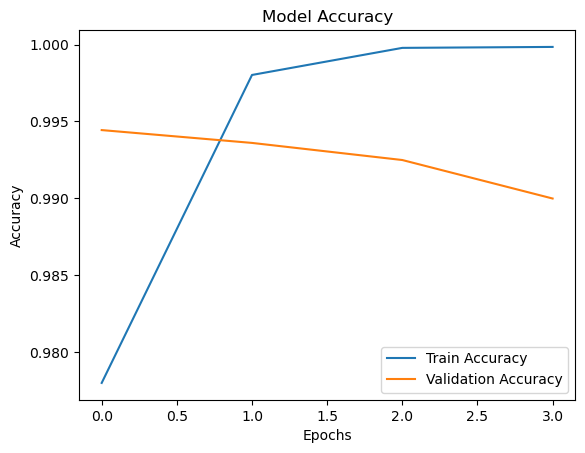

In [22]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


# Evaluate the Model

In [24]:
loss, accuracy = model.evaluate(X_test_vec, y_test)
print("Test Accuracy:", accuracy)


281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9908 - loss: 0.0397
Test Accuracy: 0.9913140535354614


# Classification Report

In [26]:
y_pred_prob = model.predict(X_test_vec)
y_pred = (y_pred_prob > 0.5).astype(int)

print(classification_report(y_test, y_pred))


281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4733
           1       1.00      0.99      0.99      4247

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



# Save Model and Vectorizer

In [28]:
model.save("fake_news_dl_model.h5")
joblib.dump(vectorizer, "vectorizer.pkl")


['vectorizer.pkl']

# Prediction Function

In [32]:
def predict_fake_news(text):
    text = clean_text(text)
    vec = vectorizer.transform([text]).toarray()
    prediction = model.predict(vec)[0][0]
    return "Fake" if prediction < 0.5 else "Real"

# Example usage
sample = "Breaking: Narendra Modi signs new education reform law!"
print("Prediction:", predict_fake_news(sample))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction: Fake
